# Filtro de Spam

En este ejercicio, vamos a construir un filtro de Spam, a partir de una BBDD de mas de 5.000 mensajes SMS

## Importaciones

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import random

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lectura de datos

Vamos a conectar con Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
PATH_DATA= '/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/data'
MODELS_DATA= '/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leemos los datos y lo convertimos en un dataframe de pandas para trabajar mas comodamente

In [ ]:
mensajes = pd.read_csv(f'{PATH_DATA}/SMSSpamCollection', sep='\t',names=["etiqueta", "mensaje"])
mensajes.head()

,etiqueta,mensaje
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Exploración de datos

In [ ]:
mensajes.describe()

,etiqueta,mensaje
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Podemos ver que hay 5572 elementos, y solo 2 etiquetas, la etiqueta mas frecuente es ham que aparece 4825 veces

Vamos a hacer lo mismo, pero agrupado por etiqueta, para ver las estadisticas por etiqueta

In [ ]:
mensajes.groupby('etiqueta').describe()

mensaje                                                            \
           count unique                                                top   
etiqueta                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
etiqueta       
ham        30  
spam        4

Los datos mas interesantes, son el conteo por etiqueta, donde podemos var que esa claramente desbalanceado 4825 son ham, y 747 spam

Vamos a añadir tambien la longitud de los mensajes a el dataframe

In [ ]:
mensajes['longitud'] = mensajes['mensaje'].apply(len)
mensajes.head()

,etiqueta,mensaje,longitud
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Visualización de datos

Resulta mas sencillo visualizarlo por medio de un grafico, asi que vamos a graficarlo

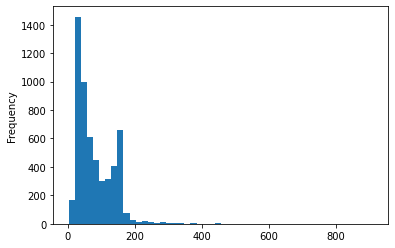

In [ ]:
mensajes['longitud'].plot(bins=50, kind='hist') 

Podemos ver claramente que la mayor parte de los mensajes son cortos, es decir por debajo de 200 caracteres

Vamso a ver las estadisticas de longitud

In [ ]:
mensajes['longitud'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: longitud, dtype: float64

Aqui esta mas claro, la media esta en 80 caracteres, pero hay mensajes de hasta 910 caracteres, vamos a ver cual es

In [ ]:
mensajes[mensajes['longitud'] == 910]['mensaje'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Vamos a explorar la longitud media de los mensajes, diferenciando entre spam y no span

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0df7e25d0>,
      dtype=object)

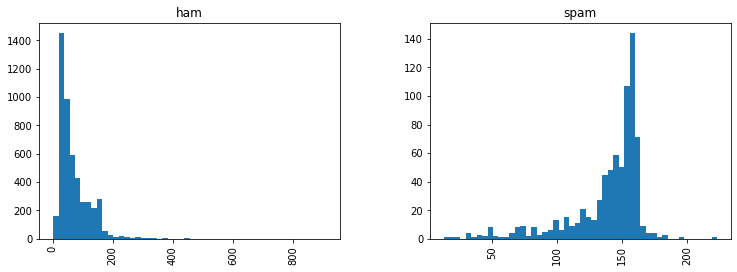

In [ ]:
mensajes.hist(column='longitud', by='etiqueta', bins=50,figsize=(12,4))

Podemos ver que los spam, en este caso son sensiblemente más largos, por termino medio

## Prepocesado

El objetivo es convertir los mensajes (secuencias de palabras) en vectores (secuencias de números)

- Primero vamos a **eliminar los caracteres de puntuación**

In [ ]:
def eliminar_puntuación(texto):
  # Check characters to see if they are in punctuation
  lista_caracteres_sin_puntuacion = [caracter for caracter in texto.lower() if caracter not in string.punctuation]
  return ''.join(lista_caracteres_sin_puntuacion)

In [ ]:
eliminar_puntuación('Sample message! Notice: it has punctuation.')

'sample message notice it has punctuation'

- Segundo vamos a **eliminar las stop words**

In [ ]:
def eliminar_stop_words(texto,language = 'english'):
  stop_words = stopwords.words(language);
  if type(texto) is list:
    return [palabra for palabra in texto if palabra not in stop_words]
  else:
    return [palabra for palabra in texto.split() if palabra not in stop_words]

In [ ]:
eliminar_stop_words('sample message notice it has punctuation')

['sample', 'message', 'notice', 'punctuation']

- Vamos a crear una función para aplicar ambas transforamciones

In [ ]:
def procesar_mensajes(texto):
  texto_limpio = eliminar_puntuación(texto)
  tokens = eliminar_stop_words(texto_limpio)
  return tokens

In [ ]:
procesar_mensajes('Sample message! Notice: it has punctuation.')

['sample', 'message', 'notice', 'punctuation']

- Vamos a actualizar el dataframe añadiendole la tokenización

In [ ]:
mensajes['mensaje'].apply(procesar_mensajes)

0       [go, jurong, point, crazy, available, bugis, n...
1                          [ok, lar, joking, wif, u, oni]
2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
3           [u, dun, say, early, hor, u, c, already, say]
4       [nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, u, £750, pou...
5568                   [ü, b, going, esplanade, fr, home]
5569                     [pity, mood, soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [rofl, true, name]
Name: mensaje, Length: 5572, dtype: object

## Vectorización

### Bolsa de palabras (BOW)

Como hemos dicho anteriormente los algoritmos de Machine LEarning, no trabajan con palabras, sino con vectores, por lo que es necesario convertir las palabras en vectores

Para ello basicamente lo haremos en 3 pasos

- Vamos a calcular la frecuencia en la que aparece cada termino

Pra ello, vamos a usar **CountVectorizer** de **SciKit Learn**, que convierte una colección de documentos de texto en una matriz donde se calcula el número de veces que aparece cada palabra en cada documento, de la siguiente forma:

|      | Message 1 | Message 2	| ...	| Message N 	|
|:----:|:----:|:----:|:----:|:----:|
| **Word 1 Count** | 0 |	1	| ... |	0 |
| **Word 2 Count** | 0 |	0	| ...	| 0 |
| **...**	| 1 |	2 |	... |	0 |
| **Word N Count** | 0 |	1 |	... |	1 |


In [ ]:
bow_transformer = CountVectorizer(analyzer=procesar_mensajes).fit(mensajes['mensaje']) # Entrenamos el modelo con lso mensajes, aplicando la funcion de procesar_mensajes 
# Mostramos el numero totol de palabras
print(len(bow_transformer.vocabulary_))

9530


In [ ]:
ind = random.randint(0,mensajes.shape[0]-1)
mensaje_ejemplo = mensajes['mensaje'][ind] # Para ver los resultados cogemos un mensaje
print('Contenido mensaje 4: ',mensaje_ejemplo,'\n') # Lo mostramos
bow_ejemplo = bow_transformer.transform([mensaje_ejemplo]) # Lo transformamos en vector de frecuencias con el bow_transformer

cx = bow_ejemplo.tolil() # Lo pasamos a listas
for id,frec in zip(cx.rows[0], cx.data[0]): # Iteramos
  print(f'Id: {id}\tPalabra: {bow_transformer.get_feature_names_out()[id]}\tFrecuencia: {frec}') # Mostramos

Contenido mensaje 4:  Okay. No no, just shining on. That was meant to be signing, but that sounds better. 

Id: 1603	Palabra: better	Frecuencia: 1
Id: 5360	Palabra: meant	Frecuencia: 1
Id: 6007	Palabra: okay	Frecuencia: 1
Id: 7396	Palabra: shining	Frecuencia: 1
Id: 7479	Palabra: signing	Frecuencia: 1
Id: 7699	Palabra: sounds	Frecuencia: 1


Generamos la bolsa de palabras

In [ ]:
bow = bow_transformer.transform(mensajes['mensaje'])

Mostramos el resultado

In [ ]:
print('Shape de la matriz dispersa: ', bow.shape)
print('Numero de elementos no cero: ', bow.nnz)
sparsity = (100.0 * bow.nnz / (bow.shape[0] * bow.shape[1]))
print('Ocupación de la matiz: {}%'.format(sparsity))

Shape de la matriz dispersa:  (5572, 9530)
Numero de elementos no cero:  50101
Ocupación de la matiz: 0.09435010459281869%


### TF-IDF

#### TF

Frecuencia del termino en el documento. Dado que hay distintas longitudes de mensajes, es muy probable que los terminos aparezcan de forma mas frecuente mensajes largos, por lo tanto se normaliza dividiendo el valor de la frecuencia, por el numero de terminos en el documento

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

#### IDF

Que da un valor relativo a la importancia del termino, por ejemplo haciendo que las palabras muy comunes en todos los documentos, tengan poca o ninguna importancia.

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).



In [ ]:
tfidf_transformer = TfidfTransformer().fit(bow) # Lo entrenamos con las bolsas de palabras
tfidf_ejemplo = tfidf_transformer.transform(bow_ejemplo)

mensaje_ejemplo = mensajes['mensaje'][ind] # Para ver los resultados cogemos un mensaje
print('Contenido mensaje 4: ',mensaje_ejemplo,'\n') # Lo mostramos

cx = tfidf_ejemplo.tolil() # Lo pasamos a listas
for id,tfidf in zip(cx.rows[0], cx.data[0]): # Iteramos
  print(f'Id: {id}\tPalabra: {bow_transformer.get_feature_names_out()[id]}\tTF-IDF: {tfidf}') # Mostramos

Contenido mensaje 4:  Okay. No no, just shining on. That was meant to be signing, but that sounds better. 

Id: 1603	Palabra: better	TF-IDF: 0.3322011726364968
Id: 5360	Palabra: meant	TF-IDF: 0.3902921482129833
Id: 6007	Palabra: okay	TF-IDF: 0.35712931131884795
Id: 7396	Palabra: shining	TF-IDF: 0.4810963977278609
Id: 7479	Palabra: signing	TF-IDF: 0.4810963977278609
Id: 7699	Palabra: sounds	TF-IDF: 0.3832304621578356


Ahora transformamos toda la bolsa de palabras

In [ ]:
messages_tfidf = tfidf_transformer.transform(bow)
print(messages_tfidf.shape)

(5572, 9530)


## Entrenar el modelo

Vamos a entrenar un modelo Naive Bayes Multinomial, usando como entradas los vectores tf-idf, construidos con la bolsa de palabras, para ver su precisión a la hora de catalogar un mensaje como Spam o como No Spam

In [ ]:
# Entrenamos el modelo pasandole los vectores tfidf y la etiqueta a predecir 
spam_detect_model = MultinomialNB().fit(messages_tfidf, mensajes['etiqueta'])

Vamos a evaluar el modelo de forma visual, cogiendo al azar n mensajes y visualizando el resultado

In [ ]:
def mostrar_evaluacion(n,model,messages_tfidf,df):
  for i in range(0,n):
    ind = random.randint(0,mensajes.shape[0])
    print(f"{'-'*100}\nMensaje: {df['mensaje'].iloc[ind]}\nPredicho: {model.predict(messages_tfidf[ind])[0]}\nReal: {df['etiqueta'].iloc[ind]}")

In [ ]:
mostrar_evaluacion(10,spam_detect_model,messages_tfidf,mensajes)

----------------------------------------------------------------------------------------------------
Mensaje: You have an important customer service announcement. Call FREEPHONE 0800 542 0825 now!
Predicho: spam
Real: spam
----------------------------------------------------------------------------------------------------
Mensaje: Thanx...
Predicho: ham
Real: ham
----------------------------------------------------------------------------------------------------
Mensaje: Hello, As per request from  &lt;#&gt;  Rs.5 has been transfered to you
Predicho: ham
Real: ham
----------------------------------------------------------------------------------------------------
Mensaje: A Boy loved a gal. He propsd bt she didnt mind. He gv lv lttrs, Bt her frnds threw thm. Again d boy decided 2 aproach d gal , dt time a truck was speeding towards d gal. Wn it was about 2 hit d girl,d boy ran like hell n saved her. She asked 'hw cn u run so fast?' D boy replied "Boost is d secret of my energy" n insta

## Evalaución del modelo

Para elaluar el modelo, vamos a realizar la predicción con todos los datos

In [ ]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


Veamos las estadisticas de el proceso de entrenamiento

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(mensajes['etiqueta'], all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      4825
        spam       1.00      0.83      0.91       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



![](http://kflu.github.io/2016/08/26/2016-08-26-visualizing-precision-recall/2016-08-26-visualizing-precision-recall-1.png)

Recall = Para uno de los supuestos por ejemplo es Spam, $\dfrac{AciertoPositivo}{AciertoPositivo + FalsoNegativo}$

Precisión = Para uno de los supuestos por ejemplo es Spam, $\dfrac{AciertoPositivo}{AciertoPositivo + FalloPositivo}$

Accuracy = Para uno de los supuestos por ejemplo es Spam, $\dfrac{AciertoPositivo+AciertoNegativo}{Total}$

Que tipo de fallo importa mas, depende del contexto del negocio, aqui es mejor fallar al identificar un Spam, que calificar un como Spam un mensaje normal.

Pero hay un problema importante aqui, es que estamos evalaundo el modelo, con los mismo datos con los que lo hemos entrenado, y esto puede hacer que pensemos que el modelo funciona bien, pero en realidad puede no estar generalizando. Es decir ¿como se comportara con nuevos datos?

### División en datos de entrenamiento y de test

Ahora, vamos a ser más honestos, y dividir el conjunto de datos, de forma que los datos que usemos para evaluar, no hayan participado en el entrenamiento

Ahora un 80% serviran para entrenar, y un 20% para evaluar

In [ ]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(mensajes['mensaje'], mensajes['etiqueta'], test_size=0.2)

print(f'Tamaño Entrenamiento: {len(msg_train)},\tTamaño Test: {len(msg_test)},\tTotal: {len(msg_train)+len(msg_test)}')

Tamaño Entrenamiento: 4457,	Tamaño Test: 1115,	Total: 5572


Creamos un Pipeline para realizar todas las tareas

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=procesar_mensajes)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
pipeline.fit(msg_train,label_train) # Entrenamos el Pipeline a partir de los datos de entrenamiento y las etiquetas

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function procesar_mensajes at 0x7ff0df52c0e0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [ ]:
predictions = pipeline.predict(msg_test) # Hacemos las predicciones

In [ ]:
print(classification_report(predictions,label_test)) # Y volvemos a pintar la matriz de confusión

              precision    recall  f1-score   support

         ham       1.00      0.95      0.98      1007
        spam       0.70      1.00      0.82       108

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115



El resultado es bastante bueno, parece que acertamos todos los casos de No Spam, y solo fallamos en algunos casos de Spam, que es lo que buscabamos